In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from ydata_profiling import ProfileReport
import torch

%matplotlib inline

In [2]:
df_reviews = pd.read_csv('reviews.tsv', delimiter='\t')
df_reviews

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
...,...,...
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...


In [3]:
label_mapping = {"Positive": 1, "Negative":0}
# label_mapping = {"Positive": 1, "Negative":0, "Mixed":2}
df_reviews = df_reviews[df_reviews.label != "Mixed"]
print(df_reviews.shape)
df_reviews.label = df_reviews.label.map(label_mapping)
df_reviews.label.value_counts()

(66666, 2)


C:\Users\HP\AppData\Local\Temp\ipykernel_2440\1177573645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews.label = df_reviews.label.map(label_mapping)


1    33333
0    33333
Name: label, dtype: int64

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using {torch.cuda.device_count()} GPU(s)!')
    print(f'Device name: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('No GPU available.')

No GPU available.


In [5]:
from transformers import AutoTokenizer, AutoModel

In [6]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

In [7]:
def text_preprocessing(text):
    text = unicodedata.normalize('NFC', text)
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '<URL>', text)
    
    return text

In [8]:
import emoji 
import unicodedata

def preprocessing_for_bert(data, version='mini', text_preprocessing_fn = text_preprocessing):
    
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-mini-arabic') \
        if version == 'mini' \
        else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
    
    for i, sent in enumerate(data):
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_fn(sent),
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks
    

In [9]:
from sklearn.model_selection import train_test_split
X = df_reviews.text.values
y = df_reviews.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [10]:
MAX_LEN = 280

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print(f'Original: {X[0]}')
print(f'Token IDs: {token_ids}')

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original: ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم
Token IDs: [2, 11774, 12428, 1809, 18, 12629, 10007, 10079, 2911, 1043, 2632, 5313, 1025, 18, 16665, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 16

In [12]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader= DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [13]:
%%time

import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False, version='mini'):
        super(BertClassifier, self).__init__()
        D_in = 256 if version == 'mini' else 758
        H = 50
        D_out = 2
#         D_out = 3
        
        self.bert = AutoModel.from_pretrained('asafaya/bert-mini-arabic') \
            if version == 'mini' \
            else AutoModel.from_pretrained('asafaya/bert-base-arabic')
        
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

CPU times: total: 78.1 ms
Wall time: 109 ms


In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam

def initialize_model(epochs=4, version='mini'):
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    bert_classifier.to(device)
    
    optimizer = AdamW(params=list(bert_classifier.parameters()), lr=5e-5, eps=1e-8)
    
    total_steps = len(train_dataloader) * epochs
    
    schedular = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    return bert_classifier, optimizer, schedular

In [15]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    
    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        
        t0_epoch, t0_batch = time.time(), time.time()
        
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            model.zero_grad()
            
            logits = model(b_input_ids, b_attn_mask)
            
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
                
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [16]:
def evaluate(model, val_dataloader):
    model.eval()
    
    val_accuracy = []
    val_loss = []
    
    for batch in val_dataloader:
        
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        preds = torch.argmax(logits, dim=1).flatten()
        
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    
    return val_loss, val_accuracy

In [ ]:
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at asafaya/bert-mini-arabic were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be rem

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   100   |   0.656655   |     -      |     -     |  323.43  


In [17]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    
    model.eval()
    
    all_logits = []
    
    for batch in test_dataloader:
        
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            
        all_logits.append(logits)
        
    all_logits = torch.cat(all_logits, dim=0)
    
    props = F.softmax(all_logits, dim=1).cpu().numpy()
    
    return props

In [18]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(props, y_true, model_name, dataset_name, test_dataset_name):
    
    preds = props[:, 1]
    
    fpr, tpr, threshold = roc_curve(y_true, preds)
    
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    plt.title(f" ROC of {model_name}  trained on {dataset_name} dataset & evaluated on the {test_dataset_name} dataset ")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
probs = bert_predict(bert_classifier, val_dataloader)

evaluate_roc(probs, y_val, "BERT-mini", "arabic-100k-reviews", "arabic-100k-reviews validation")

NameError: name 'bert_classifier' is not defined

In [24]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [25]:
probs = bert_predict(bert_classifier, test_dataloader)

threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

print("no-negative reviews ratio ", preds.sum()/len(preds))

no-negative reviews ratio  0.5209239538023099


AUC: 0.9498
Accuracy: 87.67%


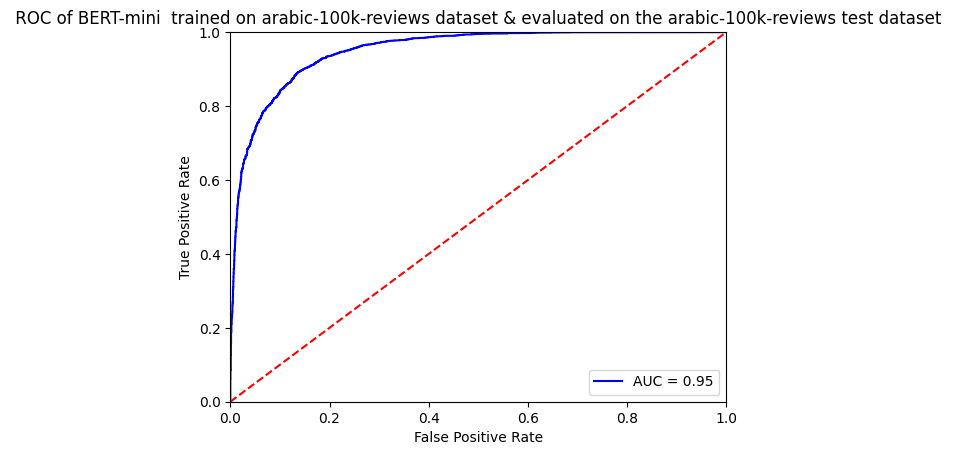

In [26]:
evaluate_roc(probs, y_test,"BERT-mini", "arabic-100k-reviews","arabic-100k-reviews test")

In [38]:
def predict_sentiment(text):
    df = pd.DataFrame([text])
    df = df.rename(columns = {0:"text"})
    print(df.text.values)
    test_inputs, test_masks = preprocessing_for_bert(df.text.values)


    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

    probs = bert_predict(bert_classifier, test_dataloader)
    print(probs)

    threshold = 0.5
    preds = np.where(probs[:, 1] > threshold, "positive", "negative")


    return preds

In [44]:
text = input("Enter a sentence:")
predict_sentiment(text)

Enter a sentence:الحياة جميلة
['الحياة جميلة']
[[0.08602934 0.91397065]]


array(['positive'], dtype='<U8')

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
cv = CountVectorizer()
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [20]:
y_pred = clf.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3324
           1       0.84      0.78      0.81      3343

    accuracy                           0.82      6667
   macro avg       0.82      0.82      0.82      6667
weighted avg       0.82      0.82      0.82      6667



C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2326: UserWarning: labels size, 10, does not match size of target_names, 2
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarni

Axes(0.125,0.11;0.62x0.77)
Accuracy: 81.55%


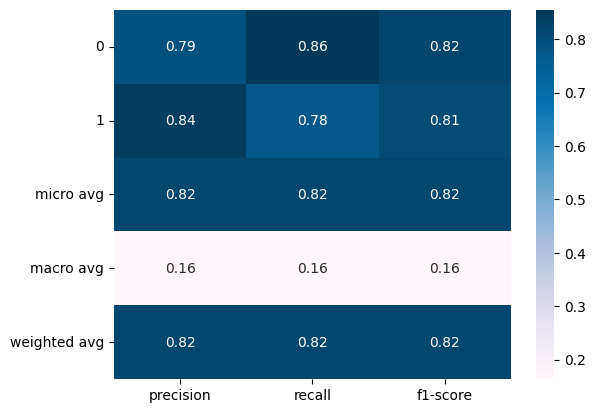

In [31]:
import numpy as np
import seaborn as sns
import pandas as pd

true = np.random.randint(0, 10, size=100)
pred = np.random.randint(0, 10, size=100)
labels = np.arange(10)
target_names = list("01")

clf_report = classification_report(y_test,
                                   y_pred,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

print(sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, cmap="PuBu", annot=True))
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy,4)*100}%" )

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictMatrix= confusion_matrix(y_test, y_pred)
predictMatrix

array([[2843,  481],
       [ 749, 2594]], dtype=int64)

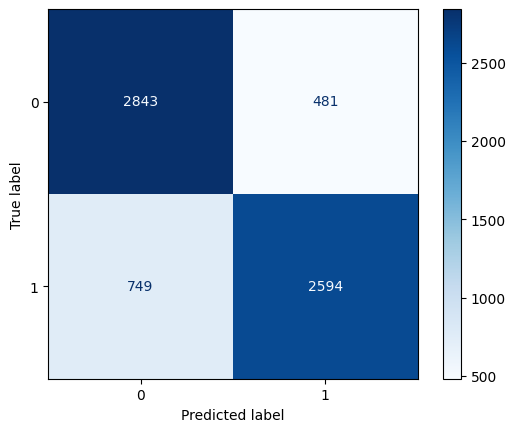

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()